In [1]:
%reload_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import os
import pandas as pd
from acled_conflict_analysis import visuals
from acled_conflict_analysis import analysis
from acled_conflict_analysis import extraction

from datetime import datetime

from bokeh.models import TabPanel, Tabs
from bokeh.plotting import show, output_notebook

# Analysing Conflict before and after the fall of the Assad Regime

In [2]:

COUNTRIES_OF_INTEREST = ["Syria"]

TODAY_DATE = datetime.today().date().isoformat()

START_DATE = '2024-01-01'
END_DATE = TODAY_DATE

In [4]:
# ============================
# LOAD AND PREPROCESS DATA
# ============================
# Load environment variables from .env file
# to ensure we can access API keys
load_dotenv()

# Extract the data
data = extraction.acled_api(
    email_address=os.environ.get("ACLED_EMAIL"),
    access_key=os.environ.get("ACLED_KEY"),
    countries=COUNTRIES_OF_INTEREST,
    start_date=START_DATE,
    end_date=END_DATE,
)

# Perfom data conversion
analysis.data_type_conversion(data)

c:\WBG\Anaconda3\envs\acled\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.acleddata.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [5]:
data['nrEvents'] = 1

In [6]:
def get_conflict_category(date):
    if date <= pd.Timestamp('2024-11-26'):
        return 'Before HTS'
    elif date <= pd.Timestamp('2024-12-08'):
        return 'Regime Change'
    else:
        return 'After Assad'

In [7]:
data.loc[:,'category'] =data['event_date'].apply(get_conflict_category)

In [ ]:
data.to_csv('../../data/conflict/raw_acled_20250505.csv')
data = pd.read_csv('../../data/conflict/raw_acled_20250505.csv')

In [8]:
conflict_daily = analysis.get_acled_by_group(
    data, columns=["latitude", "longitude", "category"], freq="D"
)

In [138]:
daily_mean = conflict_daily.groupby(['category','latitude','longitude'])[['nrEvents', 'nrFatalities']].mean().reset_index()
daily_median = conflict_daily.groupby(['category','latitude','longitude'])[['nrEvents', 'nrFatalities']].median().reset_index()

In [139]:
daily_mean = analysis.convert_to_gdf(daily_mean)
daily_median = analysis.convert_to_gdf(daily_median)

In [11]:
import geopandas as gpd
syria_adm1 = gpd.read_file('../../data/boundaries/syr_admin1.shp')

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

def get_maps(daily_mean, title):
    fig, ax = plt.subplots(1, 3, figsize=(10,4))

    vmin = min(daily_mean['nrEvents'].min(), daily_mean['nrFatalities'].min())
    vmax = max(daily_mean['nrEvents'].max(), daily_mean['nrFatalities'].max())

    for idx, period in enumerate(['Before HTS', 'Regime Change', 'After Assad']):
        syria_adm1.boundary.plot(ax=ax[idx], color='lightgrey', alpha=0.5, linewidth=1)
        
        # Plot events (blues)
        events_data = daily_mean[daily_mean['category'] == period]
        events_data.plot(
            ax=ax[idx], color='blue', alpha=0.8,vmin=vmin*5, vmax=vmax*5,
            markersize=events_data['nrEvents']*5)
        
        # Plot fatalities (reds)
        fatalities_data = daily_mean[daily_mean['category'] == period]
        fatalities_data.plot(
            ax=ax[idx], color='red', alpha=0.5,vmin=vmin*5, vmax=vmax*5,
            markersize=fatalities_data['nrFatalities']*5)
        
        # Add size legend (on the last subplot only)
        if idx == 2:
            
            # Create custom legend handles for Fatalities
            fat_values = [vmin, 
                         vmin + (vmax - vmin)/3, 
                         vmin + 2*(vmax - vmin)/3, 
                         vmax]
            fat_labels = [f"{int(val)}" for val in fat_values]
            fat_handles = [Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor='red', markersize=np.sqrt(s*5), 
                                 alpha=0.5, label=l) 
                           for s, l in zip(fat_values, fat_labels)]

            #ax[idx].add_artist(event_legend)
            fat_legend = ax[idx].legend(handles=fat_handles, loc='lower right', 
                                      frameon=False)
            #print(fat_handles)
            ax[idx].add_artist(fat_legend)
        
        ax[idx].set_title(period)
        ax[idx].spines['top'].set_visible(False)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].spines['bottom'].set_visible(False)
        ax[idx].spines['left'].set_visible(False)

        ax[idx].set_xticks([])
        ax[idx].set_yticks([])

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for title
    
    plt.show();

In [194]:
def get_maps_conflict_index(daily_mean, title, column_name):

    fig, ax = plt.subplots(1, 3, figsize=(10,4))
    
    vmin = daily_mean[column_name].min()
    vmax = daily_mean[column_name].max()

    for idx, period in enumerate(['Before HTS', 'Regime Change', 'After Assad']):
        syria_adm1.boundary.plot(ax=ax[idx], color='lightgrey', alpha=0.5, linewidth=1)
        
        # Plot fatalities (reds)
        df = daily_mean[daily_mean['category'] == period]
        df.plot(
            ax=ax[idx], color='red', alpha=0.4,vmin=vmin*5, vmax=vmax*5,
            markersize=df[column_name]*5)
        
        # Add size legend (on the last subplot only)
        if idx == 2:
            
            # Create custom legend handles for Fatalities
            fat_values = [vmin, 
                            vmin + (vmax - vmin)/3, 
                            vmin + 2*(vmax - vmin)/3, 
                            vmax]
            fat_labels = [f"{int(val)}" for val in fat_values]
            fat_handles = [Line2D([0], [0], marker='o', color='w', 
                                    markerfacecolor='red', markersize=np.sqrt(s*5), 
                                    alpha=0.5, label=l) 
                            for s, l in zip(fat_values, fat_labels)]

            #ax[idx].add_artist(event_legend)
            fat_legend = ax[idx].legend(handles=fat_handles, loc='lower right', 
                                        frameon=False)
            #print(fat_handles)
            ax[idx].add_artist(fat_legend)
        
        ax[idx].set_title(period)
        ax[idx].spines['top'].set_visible(False)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].spines['bottom'].set_visible(False)
        ax[idx].spines['left'].set_visible(False)

        ax[idx].set_xticks([])
        ax[idx].set_yticks([])

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for title

    plt.show();

## No spatial aggregation 

### Mean Conflict Events and Fatalities

**What are the average number of events per day occuring in Syria during the three time periods?**

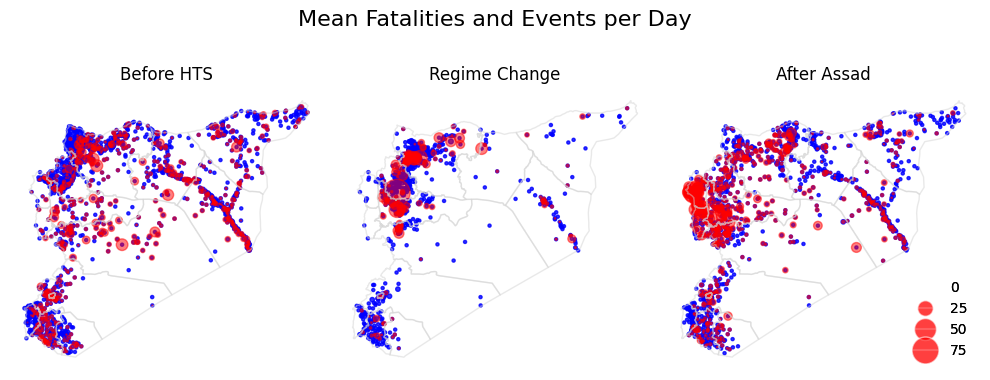

In [140]:
get_maps(daily_mean, 'Mean Fatalities and Events per Day')

### Median Conflict Events and Fatalities

**What is the most number of conflict events and fatalities that have occured in a given point in Syria?**

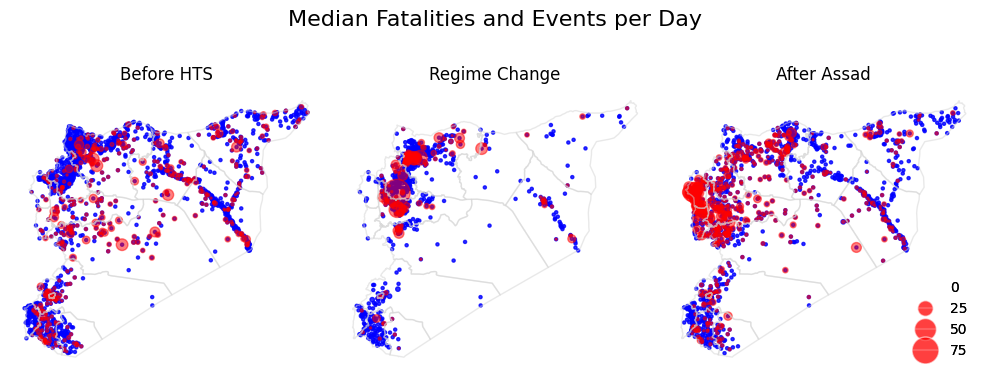

In [141]:
get_maps(daily_median, 'Median Fatalities and Events per Day')

### Mean Conflict Index

The conflict intensity index is calculated as the geometric mean of conflict events and fatalities, with an adjustment to handle zero values:

$$\text{Conflict Intensity Index} = \sqrt{(\text{nrEvents} + 0.005) \times (\text{nrFatalities} + 0.005)}$$

Where:
- $\text{nrEvents}$ is the number of conflict events in a given period and location
- $\text{nrFatalities}$ is the number of fatalities from conflicts in the same period and location
- The addition of 0.005 to each term ensures the index is defined even when either component is zero. This is arbitrary and is doen just to account for 0 values of fatalities and conflicts. 

This index provides a balanced measure that accounts for both the frequency of conflicts and their severity.  Compared to arithmetic means, the geometric mean reduces the influence of extreme values in either component (conflict events + fatalities). Areas with both high events and high fatalities will have higher index values than areas with many events but few fatalities or vice versa.

In [208]:
import numpy as np
conflict_daily['conflict_intensity_index_op1'] = np.sqrt((conflict_daily['nrEvents'] + 0.005) * 
                                           (conflict_daily['nrFatalities'] + 0.005))

In [209]:
daily_conflict_intensity = conflict_daily.groupby(['category','latitude','longitude'])[['nrEvents', 'nrFatalities', 'conflict_intensity_index_op1']].mean().reset_index()
daily_conflict_intensity = analysis.convert_to_gdf(daily_conflict_intensity)

In [211]:
daily_conflict_intensity_median = conflict_daily.groupby(['category','latitude','longitude'])[['nrEvents', 'nrFatalities', 'conflict_intensity_index_op1']].median().reset_index()
daily_conflict_intensity_median = analysis.convert_to_gdf(daily_conflict_intensity_median)

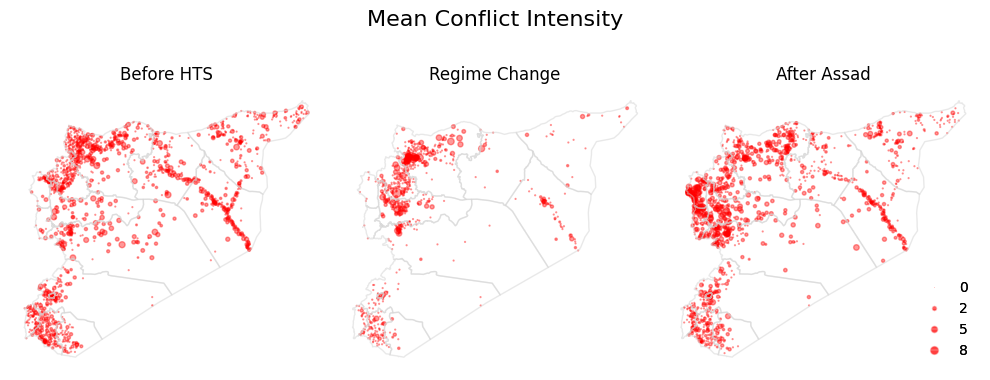

In [210]:
get_maps_conflict_index(daily_conflict_intensity, 'Mean Conflict Intensity', 'conflict_intensity_index_op1')

In [ ]:
import geopandas as gpd
import h3
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt

def convert_to_h3_grid(gdf, resolution=7, sampling_factor=200):
    """
    Convert a GeoDataFrame to H3 hexagonal grid cells with improved coverage.
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        Input spatial data
    resolution : int
        H3 resolution (0-15, where higher numbers mean smaller cells)
        Resolution 7 has cells ~5km across
    sampling_factor : int
        Number of points to sample in each dimension (higher = more complete coverage)
        
    Returns:
    --------
    GeoDataFrame with H3 hexagons
    """
    # Get the bounds of the input GeoDataFrame
    bounds = gdf.total_bounds
    
    # Create a finer grid of points covering the area
    x_range = np.arange(bounds[0], bounds[2], (bounds[2] - bounds[0]) / sampling_factor)
    y_range = np.arange(bounds[1], bounds[3], (bounds[3] - bounds[1]) / sampling_factor)
    
    # Create H3 indices for the grid of points
    h3_indices = set()
    
    # First, get H3 cells for each vertex of each polygon
    if hasattr(gdf, 'geometry') and gdf.geometry is not None:
        for geom in gdf.geometry:
            if geom.geom_type == 'Polygon':
                for x, y in geom.exterior.coords:
                    h3_indices.add(h3.latlng_to_cell(y, x, resolution))
                for interior in geom.interiors:
                    for x, y in interior.coords:
                        h3_indices.add(h3.latlng_to_cell(y, x, resolution))
            elif geom.geom_type == 'MultiPolygon':
                for poly in geom.geoms:
                    for x, y in poly.exterior.coords:
                        h3_indices.add(h3.latlng_to_cell(y, x, resolution))
                    for interior in poly.interiors:
                        for x, y in interior.coords:
                            h3_indices.add(h3.latlng_to_cell(y, x, resolution))
    
    # Then sample points throughout the area
    for x in x_range:
        for y in y_range:
            # Check if the point is within any polygon in the GeoDataFrame
            point = Point(x, y)
            if any(geom.contains(point) for geom in gdf.geometry):
                # Get the H3 index for this point
                h3_index = h3.latlng_to_cell(y, x, resolution)
                h3_indices.add(h3_index)
    
    # Fill in gaps using k-ring neighbors
    # Create a copy to iterate over while modifying the original set
    initial_indices = list(h3_indices)
    for h3_index in initial_indices:
        # Add immediate neighbors (k=1)
        neighbors = h3.grid_disk(h3_index, k=1)
        for neighbor in neighbors:
            # For each neighbor, check if it's mostly within the polygon
            boundary = h3.cell_to_boundary(neighbor)
            # Convert to shapely polygon
            hex_poly = Polygon([(lng, lat) for lat, lng in boundary])
            # Check if hexagon center is within any polygon in the gdf
            center = h3.cell_to_latlng(neighbor)
            center_point = Point(center[1], center[0])  # lng, lat
            if any(geom.contains(center_point) for geom in gdf.geometry):
                h3_indices.add(neighbor)
    
    # Create hexagons for each H3 index
    hexagons = []
    for h3_index in h3_indices:
        # Get the boundary of the hexagon
        boundaries = h3.cell_to_boundary(h3_index)
        # Convert to shapely polygon (note: h3 returns [lat, lng] but Shapely expects [lng, lat])
        polygon = Polygon([(lng, lat) for lat, lng in boundaries])
        hexagons.append({'h3_index': h3_index, 'geometry': polygon})
    
    # Create a GeoDataFrame with the hexagons
    h3_gdf = gpd.GeoDataFrame(hexagons, crs=gdf.crs)
    
    return h3_gdf


In [27]:
syria_adm0 = gpd.read_file('../../data/boundaries/syr_admin0.shp')

## Hexagonal Aggregation
Below are maps where the fatalities and conflict events are aggregated to hexagons of size 276 sq km each. This shows greater variance spatially.

In [230]:
syria_h3 = convert_to_h3_grid(syria_adm0, resolution=5)

In [146]:
data['event_date'] = pd.to_datetime(data['event_date'])

In [231]:
conflict_daily_h3 = analysis.get_acled_by_admin(syria_h3, data, columns=['h3_index', 'category'], freq='D')
conflict_daily_h3.drop(columns=['index'], inplace=True)

In [232]:
conflict_daily_h3['conflict_intensity_index_op1'] = np.sqrt((conflict_daily_h3['nrEvents'] + 0.005) * 
                                           (conflict_daily_h3['nrFatalities'] + 0.005))

In [233]:
conflict_daily_h3 = conflict_daily_h3.groupby(['h3_index', 'category'])[['nrEvents', 'nrFatalities', 'conflict_intensity_index_op1']].mean().reset_index()

In [234]:
conflict_daily_h3 = syria_h3.merge(conflict_daily_h3, on='h3_index', how='left')

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def get_h3_maps(daily_mean, title, measure='nrEvents'):
    """
    Plot H3 grids with color representing the specified measure divided into quartiles
    
    Parameters:
    -----------
    daily_mean : GeoDataFrame
        The data to plot
    title : str
        The title for the figure
    measure : str
        The measure to plot on color scale (can be any numeric column)
    """
    # Set up the figure
    fig, ax = plt.subplots(1, 3, figsize=(10,4))
    
    # Choose colormap based on measure
    if measure == 'nrEvents':
        cmap = 'Blues' 
    elif measure =='nrFatalities':
        cmap = 'Reds'
    else:
        cmap = 'Purples'
    
    # Create a deep copy of the dataframe to avoid the SettingWithCopyWarning
    plot_data = daily_mean.copy(deep=True)
    
    # Filter out NaN values for calculations
    non_nan_data = plot_data[plot_data[measure].notna()]
    
    # Get min and max for legend
    vmin = non_nan_data[measure].min()
    vmax = non_nan_data[measure].max()
    
    # Manually create 4 equal-sized groups
    try:
        # Try to create exactly 4 equal-sized groups
        # First, calculate the quantiles
        q_values = [0, 0.25, 0.5, 0.75, 1.0]
        quantiles = non_nan_data[measure].quantile(q_values).tolist()
        
        # Handle the case where there are duplicate values at quantile boundaries
        unique_quantiles = []
        for q in quantiles:
            if q not in unique_quantiles:
                unique_quantiles.append(q)
                
        # If all values are the same, add a small increment to create distinctions
        if len(unique_quantiles) == 1:
            epsilon = 1e-10
            unique_quantiles = [unique_quantiles[0] - epsilon, 
                               unique_quantiles[0],
                               unique_quantiles[0] + epsilon,
                               unique_quantiles[0] + 2*epsilon,
                               unique_quantiles[0] + 3*epsilon]
                               
        # If we have fewer than 5 edges (needed for 4 bins), add intermediates
        while len(unique_quantiles) < 5:
            for i in range(len(unique_quantiles)-1):
                mid = (unique_quantiles[i] + unique_quantiles[i+1]) / 2
                if mid not in unique_quantiles:
                    unique_quantiles.insert(i+1, mid)
                    break
            
        # Ensure we have exactly 5 quantiles for 4 bins
        unique_quantiles = unique_quantiles[:5]
        
        # Create quartile categories using pd.cut() with our manual bins
        quartile_categories = pd.cut(
            plot_data[measure],
            bins=unique_quantiles,
            labels=['Q1', 'Q2', 'Q3', 'Q4'],
            include_lowest=True
        )
        
        # Store the bin edges for the legend
        bin_edges = unique_quantiles
        
    except (ValueError, IndexError):
        # Fallback to hardcoded bins if we still have issues
        min_val = non_nan_data[measure].min()
        max_val = non_nan_data[measure].max()
        step = (max_val - min_val) / 4
        
        # Create evenly spaced bins
        bin_edges = [min_val + i * step for i in range(5)]
        if bin_edges[0] == bin_edges[1]:  # Avoid duplicate lower bound
            bin_edges[0] -= 0.0001
            
        # Create quartile categories
        quartile_categories = pd.cut(
            plot_data[measure],
            bins=bin_edges,
            labels=['Q1', 'Q2', 'Q3', 'Q4'],
            include_lowest=True
        )
    
    # Convert to string to avoid dtype incompatibility
    plot_data = plot_data.assign(quartile=quartile_categories.astype(str))
    
    for idx, period in enumerate(['Before HTS', 'Regime Change', 'After Assad']):
        # Plot Syria boundary
        syria_adm1.boundary.plot(ax=ax[idx], color='lightgrey', alpha=0.5, linewidth=1)
        
        # Filter data for the current period
        period_data = plot_data[plot_data['category'] == period]
        
        # Plot the data with discrete colors based on quartiles
        period_data.plot(
            ax=ax[idx], 
            column='quartile',  # Use the quartile column
            categorical=True,
            cmap=cmap, 
            alpha=0.7,
            markersize=8,  # Fixed marker size
            legend=False
        )
        
        # Set title and remove spines/ticks
        ax[idx].set_title(period)
        ax[idx].spines['top'].set_visible(False)
        ax[idx].spines['right'].set_visible(False)
        ax[idx].spines['bottom'].set_visible(False)
        ax[idx].spines['left'].set_visible(False)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
    
    # Create a custom legend
    from matplotlib.patches import Patch
    colors = plt.colormaps[cmap](np.linspace(0.2, 0.8, 4))  # Always 4 colors
    
    # Create legend elements for exactly 4 quartiles
    legend_elements = []
    for i in range(4):
        legend_elements.append(
            Patch(
                facecolor=colors[i], 
                edgecolor='none', 
                alpha=0.7, 
                label=f'Q{i+1} ({bin_edges[i]:.2f}-{bin_edges[i+1]:.2f})'
            )
        )
    
    # Add legend to the figure
    fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, 0.01))
    
    plt.suptitle(title, fontsize=16)
    fig.set_constrained_layout(True)  # Use constrained layout instead of tight_layout
    
    return fig, ax

### Mean Conflict Index

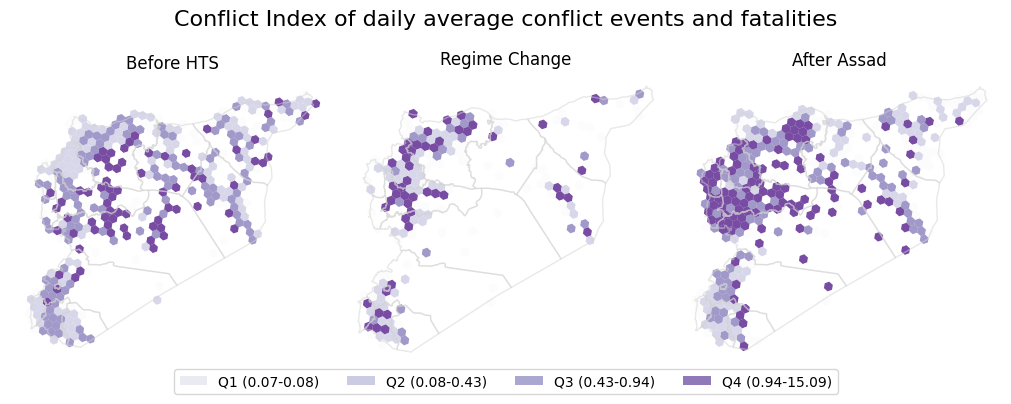

In [235]:
fig, ax = get_h3_maps(conflict_daily_h3, 'Conflict Index of daily average conflict events and fatalities', measure='conflict_intensity_index_op1')


The average conflict index measure shows the difference in the three periods very effectively compared to a showing mean conflict events and fatalities separately on the same map. 

### Mean Conflict Events

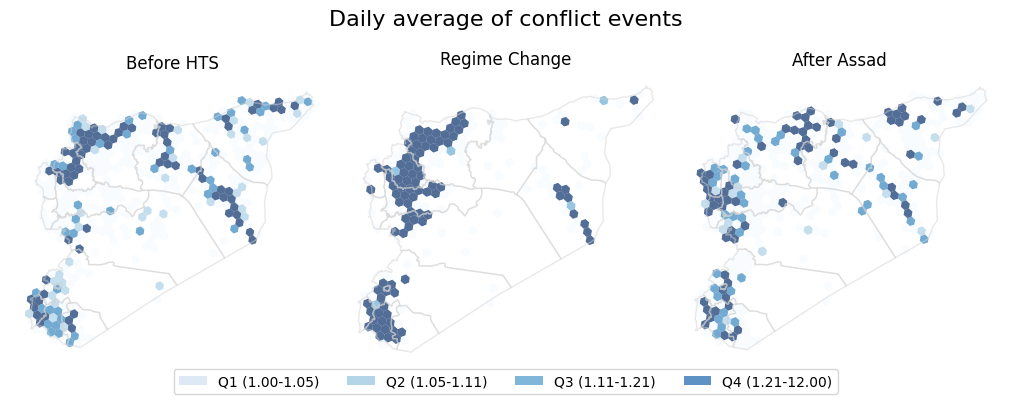

In [202]:
fig, ax = get_h3_maps(conflict_daily_h3, 'Daily average of conflict events', measure='nrEvents')

### Mean Fatalities

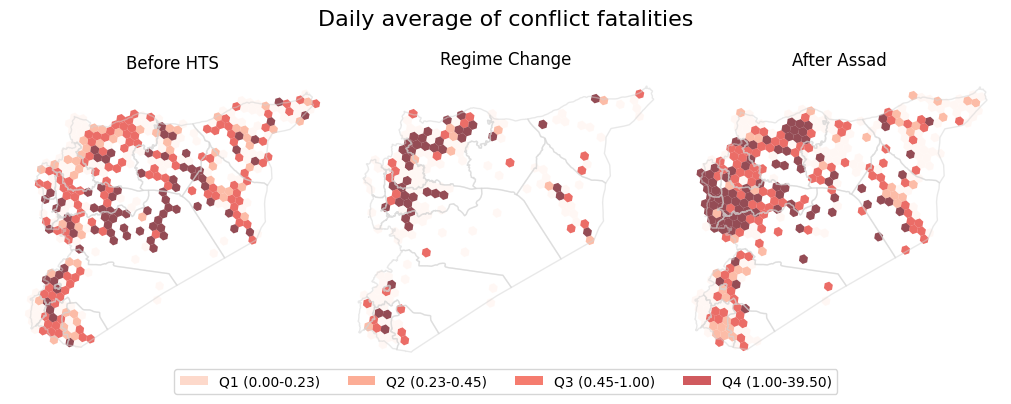

In [203]:
fig, ax = get_h3_maps(conflict_daily_h3, 'Daily average of conflict fatalities', measure='nrFatalities')

## Bivariate Conflict Map

This last option does not use any formula on conflict events or fatalities, it simply uses one single color to show the combination of these two. 

Conflict events and fatalities are divided into low-medium and high (equal quantiles of the data) and color is given accordingly. 

In [222]:
def create_bivariate_conflict_map(conflict_data, title="Conflict Patterns: Events × Fatalities"):
    # Set up figure
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    plot_data = conflict_data.copy(deep=True)
    
    # Remove NaN values for calculations
    events_data = plot_data['nrEvents'].dropna()
    fatalities_data = plot_data['nrFatalities'].dropna()
    
    # Calculate quantiles and ensure unique bin edges
    def create_unique_bins(data, num_bins=3):  # Changed to 3 bins
        quantiles = [0, 0.33, 0.67, 1.0]  # Changed to 3 equal quantiles
        bins = data.quantile(quantiles).tolist()
        # Ensure bins are unique by adding small increments
        for i in range(1, len(bins)):
            if bins[i] <= bins[i-1]:
                bins[i] = bins[i-1] + 0.000001
        return bins
    
    events_bins = create_unique_bins(events_data)
    fatalities_bins = create_unique_bins(fatalities_data)
    
    # Create categories
    plot_data['events_category'] = pd.cut(
        plot_data['nrEvents'], 
        bins=events_bins,
        labels=['Low', 'Medium', 'High'],  # Changed to 3 categories
        include_lowest=True
    )
    
    plot_data['fatalities_category'] = pd.cut(
        plot_data['nrFatalities'], 
        bins=fatalities_bins,
        labels=['Low', 'Medium', 'High'],  # Changed to 3 categories
        include_lowest=True
    )
    
    # Create color dictionary with 3×3 matrix (9 colors)
    colors = {
        ('Low', 'Low'): (0.85, 0.85, 0.85, 1),           # Light gray
        ('Low', 'Medium'): (0.9, 0.6, 0.6, 1),           # Medium pink
        ('Low', 'High'): (0.9, 0.2, 0.2, 1),             # Red
        
        ('Medium', 'Low'): (0.6, 0.6, 0.9, 1),           # Medium blue
        ('Medium', 'Medium'): (0.7, 0.5, 0.7, 1),        # Purple
        ('Medium', 'High'): (0.8, 0.3, 0.5, 1),          # Dark pink
        
        ('High', 'Low'): (0.2, 0.2, 0.9, 1),             # Blue
        ('High', 'Medium'): (0.4, 0.2, 0.7, 1),          # Dark purple
        ('High', 'High'): (0.4, 0.1, 0.4, 1)             # Very dark purple
    }
    
    # Assign colors
    plot_data['color'] = plot_data.apply(
        lambda row: colors.get((row['events_category'], row['fatalities_category']), 
                              (0.8, 0.8, 0.8, 0.3)) 
        if not pd.isna(row['events_category']) and not pd.isna(row['fatalities_category']) 
        else (0.8, 0.8, 0.8, 0.3), 
        axis=1
    )
    
    # Plot each period
    for idx, period in enumerate(['Before HTS', 'Regime Change', 'After Assad']):
        # Plot the Syria administrative boundaries
        syria_adm1.boundary.plot(ax=ax[idx], color='lightgrey', alpha=0.5, linewidth=1)
        
        # Filter data for this period
        period_data = plot_data[plot_data['category'] == period]
        
        # Plot filled H3 grid cells
        for _, row in period_data.iterrows():
            if not pd.isna(row['color']):
                # Plot the polygon geometry with fill color
                ax[idx].fill(*row.geometry.exterior.xy, color=row['color'], alpha=0.8)
        
        ax[idx].set_title(period, fontsize=14)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        for spine in ax[idx].spines.values():
            spine.set_visible(False)
    
    # Add legend
    legend_ax = fig.add_axes([0.28, 0.05, 0.44, 0.15], frameon=True)
    legend_ax.set_facecolor('white')
    
    categories = ['Low', 'Medium', 'High']  # Changed to 3 categories
    for i, event_cat in enumerate(categories):
        for j, fatal_cat in enumerate(categories):
            legend_ax.add_patch(plt.Rectangle(
                (j, i), 1, 1, color=colors[(event_cat, fatal_cat)]
            ))
    
    legend_ax.text(1.0, -0.5, "Fatalities →", ha='center', fontsize=12, fontweight='bold')
    legend_ax.text(-0.5, 1.0, "Events →", va='center', rotation=90, fontsize=12, fontweight='bold')
    
    for i, cat in enumerate(categories):
        legend_ax.text(i + 0.5, -0.2, cat, ha='center', fontsize=9)
        legend_ax.text(-0.2, i + 0.5, cat, va='center', fontsize=9)
    
    legend_ax.set_xlim(-0.7, 3.2)  # Adjusted for 3 categories
    legend_ax.set_ylim(-0.7, 3.2)  # Adjusted for 3 categories
    legend_ax.axis('off')
    
    plt.suptitle(title, fontsize=16, y=0.97)
    
    return fig, ax

### Combination of mean conflict events and fatalities

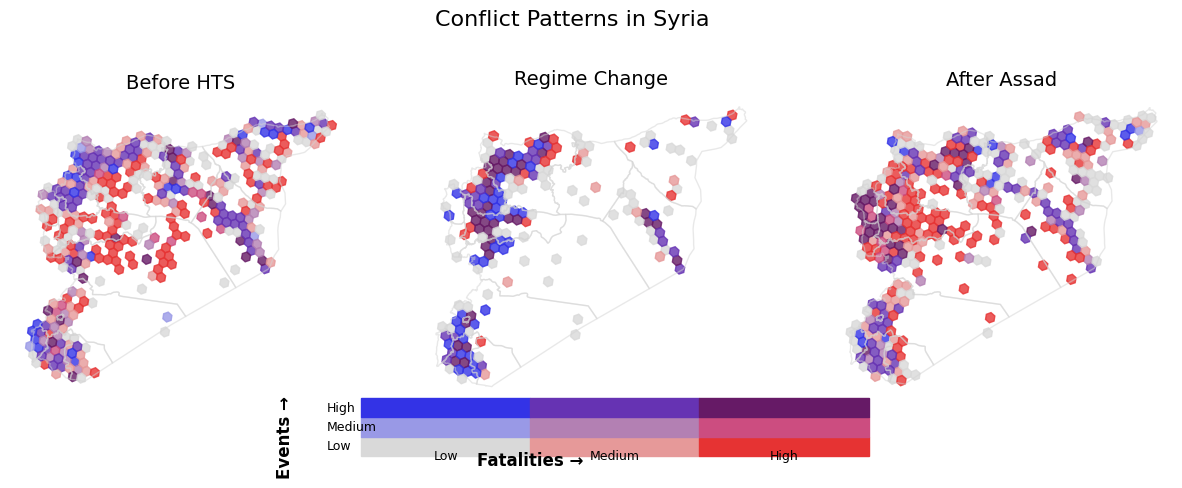

In [223]:
fig, ax = create_bivariate_conflict_map(conflict_daily_h3, "Conflict Patterns in Syria")
